# Unaccounted uncertainty

The uncertainty in the ordinate of a given dataset may not necessarily represent the **true** uncertainty in the data. 
For example, systematic uncertainty may be present which can cause incorrect results in an analysis. 

However, it is possible to account for this, and using Bayesian evidence determine if it is a correct to do so. 
Consider the data below, where the noise in the ordinate increases with the abscissa value.
It is clear that the uncertainty in the data does not fully account for the noise. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

In [3]:
x = np.arange(1, 11)
y = np.random.random((10)) + 10
y += y * np.random.randn(10) * x * 0.05
dy = np.abs(x * 0.2)

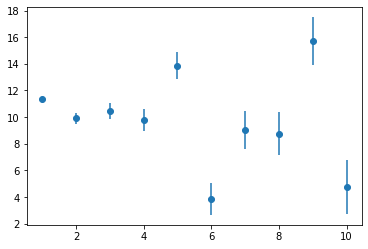

In [4]:
plt.errorbar(x, y, dy, marker='o', ls='')
plt.show()

Let's try using MCMC to find the average value in the ordinate.

In [5]:
def my_model(x, a):
    return np.zeros_like(x) + a

In [6]:
from uravu.relationship import Relationship

In [7]:
modeller = Relationship(my_model, x, y, dy)
modeller.max_likelihood(np.mean(y))
modeller.mcmc()

100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s]


We can use the `plotting` library to interogate the value of the mean, and the associated uncertainty. 

In [8]:
from uravu import plotting

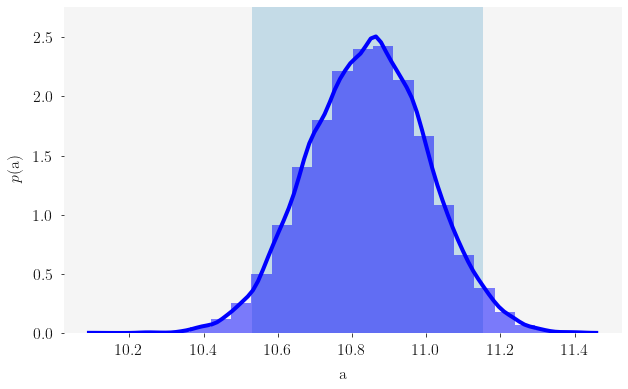

In [9]:
plotting.plot_distribution(modeller.variables[0])
plt.show()

This appears to be a reasonable value for the mean, however, as mentioned above it is possible that the uncertainty in the individual values (indeed if this is the same value over and over they should in theory overlap). 
This can be observed visually by plotting the relationship.

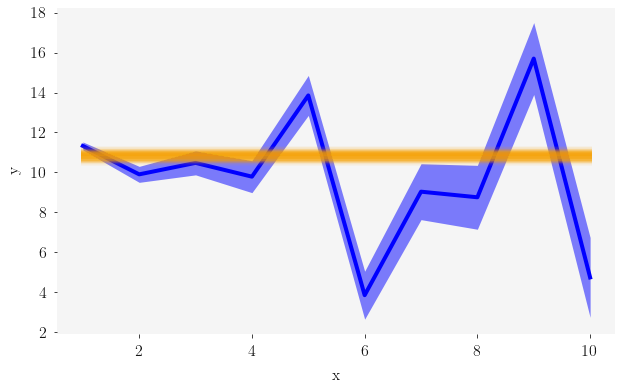

In [10]:
plotting.plot_relationship(modeller)

It is clear that this mean line is not covering all of the points. 
Let us test with the unaccounted uncertainty, which adds an additional parameter to our model. 

In [11]:
modeller2 = Relationship(my_model, x, y, dy, unaccounted_uncertainty=True)

In [12]:
modeller2.max_likelihood()

In [13]:
modeller2.mcmc()

100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


We can plot both the `a` parameter and the unaccounted uncertainty with a corner plot. 

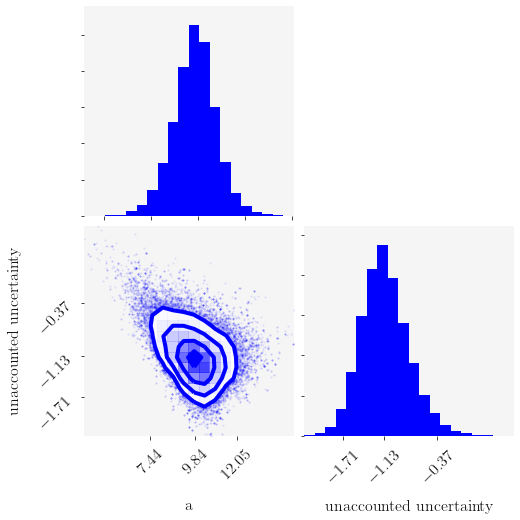

In [14]:
plotting.plot_corner(modeller2)
plt.show()

Notice that the width of the `a` distribution is much greated with the unaccounted uncertainty parameter. 
Let's try and see the effect this has on the relationship. 

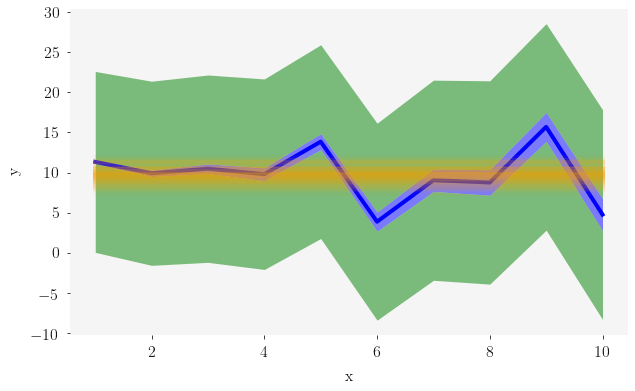

In [15]:
plotting.plot_relationship(modeller2)
plt.show()

The green shaded area is the additional unaccount uncertainty, and we can see now that the orange line is spread over much more of the plot. 

However, is this additional parameter meaningful, or are we overfitting. 
We can use the [evidence](./nested_sampling.html) to find out. 

In [16]:
modeller.nested_sampling()

3597it [00:17, 205.21it/s, +500 | bound: 5 | nc: 1 | ncall: 21341 | eff(%): 19.198 | loglstar:   -inf < -37.201 <    inf | logz: -43.485 +/-  0.137 | dlogz:  0.001 >  0.509]   


In [17]:
modeller2.nested_sampling()

3925it [00:25, 154.07it/s, +500 | bound: 8 | nc: 1 | ncall: 23272 | eff(%): 19.014 | loglstar:   -inf < -16.884 <    inf | logz: -23.885 +/-  0.156 | dlogz:  0.001 >  0.509]


In [18]:
print(modeller.ln_evidence, modeller2.ln_evidence)

-43.48+/-0.14 -23.89+/-0.16


It is clear that the modeller has a greater evidence, indicating that it is a more probable model. 